In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import pandas as pd

import matplotlib.animation as animation
import IPython

import torch.distributions as tdist

from ipywidgets import interact

from utils import *
from variational_inference_classes import *

%load_ext autoreload
%autoreload 2

# $n$-dependencies

In [7]:
k_0 = torch.tensor([7., 5.])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1., 3.])
# k_0 = torch.tensor([3., 3.])  # assume no "flat" dimensions with k_j = 0
# h_0 = torch.tensor([3., 3.])
lambda_0 = (h_0 + 1) / (2 * k_0)

lr = 0.005
num_epoch = 5000
max_num_epoch = 100000
print(
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"h_0      = {np.around(h_0.detach(), 2)}\n"
#     f"logZ     = {meanfield_truncated_gamma_restricted_on_standard_form.log_evidence():.3f}\n"
)

rec = []
for logn in range(3, 8):
    n = int(10**logn)
    vis = dict(
#         mf_gamma=MeanFieldGammaOn2DStandardForm(
#             n=n,
#             k_0=k_0,
#             lambda_0=lambda_0,
#             lr=lr, 
#             lambdas_grad=False, 
#             ks_grad=False, 
#             beta1_grad=False,
#         ), 
        mf_gamma_trunc_allbetas=MeanFieldTruncatedGammaOn2DStandardForm(
            n=n,
            k_0=k_0,
            lambda_0=lambda_0, 
            lr=lr, 
            lambdas_grad=False, 
            ks_grad=False, 
            beta1_grad=True,
            init_params=[
                lambda_0, 
                k_0, 
                torch.tensor([n, 1])
            ]
        ), 
        mf_gamma_trunc_beta2only=MeanFieldTruncatedGammaOn2DStandardForm(
            n=n,
            k_0=k_0,
            lambda_0=lambda_0, 
            lr=lr, 
            lambdas_grad=False, 
            ks_grad=False, 
            beta1_grad=False,
            init_params=[
                lambda_0, 
                k_0, 
                torch.tensor([n, 15])
            ]
        ), 
        mf_beta=MeanFieldBetaOn2DStandardForm(
            n=n,
            k_0=k_0,
            lambda_0=lambda_0, 
            lr=0.001, 
            base_samples=5000,
            init_params=[
                torch.tensor([3, 3]), 
                torch.tensor([5, 2])
            ]
        )
#         gaussian=GaussianFamilyOn2DStandardForm(
#             n=n,
#             k_0=k_0,
#             h_0=h_0, 
#             lr=lr, 
#             init_mu=torch.tensor([0.6, 0.9]),
#             init_logsigma=torch.log(torch.tensor([0.1, 1]))
#         )
    )
    for vi_name, vi in vis.items():
        logZ = vi.log_evidence()
        leading_approx = logZ_approx(k_0.numpy(), h_0.numpy(), n)
        elbo_init = vi.elbo_fn().item()
        vi.run_parameter_optimisation(num_epoch, verbose=False)
        
        # run for at least `num_epoch`, but if not converge, run another 1000 epoch until it does
        while not vi.has_converged(threshold=0.05) and vi.epoch < max_num_epoch:
            print(f"!! NOT CONVERGED ({vi_name}). Current epoch: {vi.epoch}")
            vi.run_parameter_optimisation(1000, verbose=False)
            tail_elbo_diff = np.abs(np.diff([elbo for _, elbo in vi.optim_rec[-10:]])).mean()
        
#         elbo = vi.elbo_fn().item()
        elbo = vi.max_elbo.item()
        print(f"{vi_name:30s}: n={n:12d}, logZ={logZ:.4f} ({leading_approx:.4f}), "
              f"EBLO_0={elbo_init:.4f}, ELBO={elbo:.4f}")
        
        rec.append([vi_name, n, logZ, leading_approx, elbo_init, elbo])

lambda_0 = tensor([0.1400, 0.4000])
ks_0     = tensor([7., 5.])
h_0      = tensor([1., 3.])

mf_gamma_trunc_allbetas       : n=   100000000, logZ=-4.3388 (-6.6385), EBLO_0=-4.7003, ELBO=-4.5867
mf_gamma_trunc_beta2only      : n=   100000000, logZ=-4.3388 (-6.6385), EBLO_0=-5.4415, ELBO=-4.6749
!! NOT CONVERGED (mf_beta). Current epoch: 5000
!! NOT CONVERGED (mf_beta). Current epoch: 6000
!! NOT CONVERGED (mf_beta). Current epoch: 7000
!! NOT CONVERGED (mf_beta). Current epoch: 8000
!! NOT CONVERGED (mf_beta). Current epoch: 9000
!! NOT CONVERGED (mf_beta). Current epoch: 10000
!! NOT CONVERGED (mf_beta). Current epoch: 11000
!! NOT CONVERGED (mf_beta). Current epoch: 12000
!! NOT CONVERGED (mf_beta). Current epoch: 13000
!! NOT CONVERGED (mf_beta). Current epoch: 14000
!! NOT CONVERGED (mf_beta). Current epoch: 15000
!! NOT CONVERGED (mf_beta). Current epoch: 16000
!! NOT CONVERGED (mf_beta). Current epoch: 17000
!! NOT CONVERGED (mf_beta). Current epoch: 18000
!! NOT CONVERGED (mf_bet

KeyboardInterrupt: 

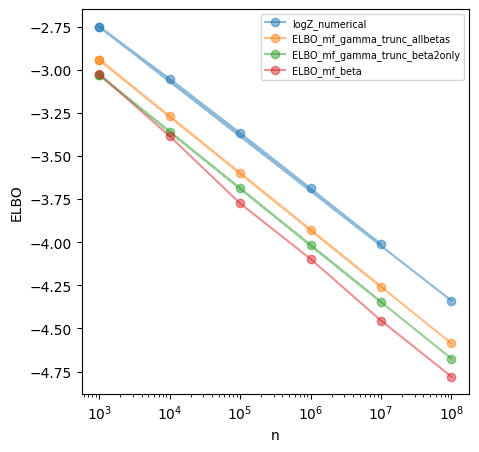

In [8]:
df = pd.DataFrame(rec, index=None)
df.columns = ["name", "n", "logZ_numerical", "logZ_leading_approx", "ELBO_init", "ELBO"]
df = df.set_index("name")
fig,ax = plt.subplots(1, 1, figsize=(5, 5))
alpha=0.5
name = df.index[0]
ax.plot(
    df.loc[name, "n"], 
    df.loc[name, "logZ_numerical"], 
    "o-", 
    label="logZ_numerical", 
    alpha=alpha
)
# ax.plot(
#     df.loc[name, "n"], 
#     df.loc[name, "logZ_leading_approx"], 
#     "o-", 
#     label="logZ_leading_approx", 
#     alpha=alpha
# )

for name in df.index.unique():
    if name in ["gaussian"]:
        continue
    d = df.loc[name, :]
    ax.plot(d["n"], d["ELBO"], "o-", label=f"ELBO_{name}", alpha=alpha)
#     ax.plot(df.loc[name, "n"], df.loc[name, "ELBO_init"], "o-", label=f"ELBO_init_{name}", alpha=alpha)
#     ax.plot(df.loc[name, "n"], df.loc[name, "ELBO"], "o-", label=f"gamma_trunc_beta2_grad", alpha=alpha)
#     ax.plot(df.loc[name, "n"], df.loc[name, "ELBO_init"], "o-", label=f"gamma_trunc_beta2_nograd", alpha=alpha)

ax.set_xscale('log')
ax.set_xlabel("n")
ax.set_ylabel("ELBO")
ax.legend(fontsize="x-small")